### Using regular expressions

In [1]:
# ! pip install pandas python-Levenshtein spacy nltk textblob tqdm transformers -U

In [2]:
import re
import pandas as pd
data_file = 'DataScientist.csv'

In [3]:
df = pd.read_csv(data_file)
df.head(2)

,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1


In [4]:
def get_items(df, regex, column_name):
    df[column_name] = df['Job Description'].apply(lambda x:re.findall(regex, x))
    return df

In [5]:
def get_list_of_items(df, column_name):
    items = []
    for index, row in df.iterrows():
        if len(row[column_name]) > 0:
            for item in list(row[column_name]):
                if (type(item) is tuple) and (len(item) > 1):
                    item = item[0]
                if item not in items:
                    items.append(item)
    return items

In [6]:
def get_emails(df):
    email_regex = '[^\s:|()\']+@[a-zA-Z0-9\.]+\.[a-zA-Z]+'
    df['emails'] = df['Job Description'].apply(lambda x: re.findall(email_regex, x))
    emails = get_list_of_items(df, 'emails')
    return emails

In [7]:
def get_urls(df):
    url_regex = '(http[s]?://(www\.)?[A-Za-z0-9–_\.\-]+\.[A-Za-z]+/?[A-Za-z0-9$\–_\-\/\.\?]*)[\.)\"]*'
    df = get_items(df, url_regex, 'urls')
    urls = get_list_of_items(df, 'urls')
    return urls

In [8]:
df = pd.read_csv(data_file, encoding='utf-8')

In [9]:
emails = get_emails(df)
print(emails[:5])

['jsmith@quartethealth.com', 'security@quartethealth.com', 'talent@quartethealth.com', 'accommodations-ext@fb.com', 'talent@ebay.com']


In [10]:
urls = get_urls(df)
print(urls[:5])

['https://www.decode-m.com/', 'https://www.amazon.jobs/en/disability/us.', 'https://www.techatbloomberg.com/nlp/', 'https://bloomberg.com/company/d4gx/', 'https://www.dol.gov/ofccp/regs/compliance/posters/ofccpost.htm']


## Finding similar strings: the Levenshtein distance

In [11]:
import pandas as pd
import Levenshtein

In [12]:
data_file = 'DataScientist.csv'

In [13]:
def find_lavenshtein(input_string, df):
    df['distance_to_' + input_string] = df['emails'].apply(lambda x: Levenshtein.distance(input_string, x))
    return df

In [14]:
def get_closest_mail_lev(df, email):
    df = find_lavenshtein(email, df)
    column_name = 'distance_to_' + email
    minimum_value_email_index = df[column_name].idxmin()
    email = df.loc[minimum_value_email_index]['emails']
    return email

In [15]:
df = pd.read_csv(data_file, encoding='utf-8')
emails  = get_emails(df)
new_df = pd.DataFrame(emails, columns=['emails'])

In [16]:
new_df.head()

,emails
0,jsmith@quartethealth.com
1,security@quartethealth.com
2,talent@quartethealth.com
3,accommodations-ext@fb.com
4,talent@ebay.com


In [17]:
input_string = "rohitt.macdonald@prelim.com"
email = get_closest_mail_lev(new_df, input_string)
print(email)

rohit.mcdonald@prolim.com


In [18]:
def find_jaro(input_string, df):
    df['distance_to_' + input_string] = df['emails'].apply(lambda x: Levenshtein.jaro(input_string, x))
    return df

In [19]:
def get_closest_email_jaro(df, email):
    df = find_jaro(email, df)
    column_name = 'distance_to_' + email
    maximum_value_email_index = df[column_name].idxmax()
    email = df.loc[maximum_value_email_index]['emails']
    return email
    

In [20]:
df = pd.read_csv(data_file, encoding='utf-8')
emails = get_emails(df)
new_df = pd.DataFrame(emails, columns=['emails'])

In [21]:
input_string = "rohitt.macdonald@prelim.com"
email = get_closest_email_jaro(new_df, input_string)
print(email)

rohit.mcdonald@prolim.com


In [22]:
print(Levenshtein.jaro_winkler("rohit.mcdonald@prolim.com",
      "rohit.mcdonald@prolim.org"))

1.0


In [23]:
# jellyfish

## Performing named entity recognition using spaCy

In [24]:
# ! pip install spacy -U

In [25]:
# ! python -m spacy download en_core_web_sm

In [26]:
import spacy

In [27]:
nlp = spacy.load('en_core_web_sm')

In [28]:
article = """iPhone 12: Apple makes jump to 5G
Apple has confirmed its iPhone 12 handsets will be its first to work on faster 5G networks. 
The company has also extended the range to include a new "Mini" model that has a smaller 5.4in screen. 
The US firm bucked a wider industry downturn by increasing its handset sales over the past year. 
But some experts say the new features give Apple its best opportunity for growth since 2014, when it revamped its line-up with the iPhone 6. 
…
"Networks are going to have to offer eye-wateringly attractive deals, and the way they're going to do that is on great tariffs and attractive trade-in deals," 
predicted Ben Wood from the consultancy CCS Insight. Apple typically unveils its new iPhones in September, but opted for a later date this year. 
It has not said why, but it was widely speculated to be related to disruption caused by the coronavirus pandemic. The firm's shares ended the day 2.7% lower. 
This has been linked to reports that several Chinese internet platforms opted not to carry the livestream, 
although it was still widely viewed and commented on via the social media network Sina Weibo."""

In [29]:
doc = nlp(article)

In [30]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

12 7 9 CARDINAL
Apple 11 16 ORG
5 31 32 CARDINAL
iPhone 58 64 ORG
12 65 67 CARDINAL
first 89 94 ORDINAL
5 113 114 CARDINAL
Mini 185 189 WORK_OF_ART
5.4 216 219 CARDINAL
US 235 237 GPE
the past year 313 326 DATE
Apple 372 377 ORG
2014 416 420 DATE
Ben Wood 643 651 PERSON
iPhones 718 725 ORG
September 729 738 DATE
a later date this year 754 776 DATE
2.7% 925 929 PERCENT
Chinese 983 990 NORP
Sina Weibo 1128 1138 PERSON


In [31]:
# ! python -m spacy download en_core_web_md

In [32]:
nlp = spacy.load('en_core_web_md')

In [33]:
doc = nlp(article)

In [34]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

iPhone 12 0 9 LAW
Apple 11 16 ORG
5 31 32 CARDINAL
G
Apple 32 39 ORG
iPhone 12 58 67 LAW
first 89 94 ORDINAL
5 113 114 CARDINAL
5.4 216 219 CARDINAL
US 235 237 GPE
the past year 313 326 DATE
Apple 372 377 ORG
2014 416 420 DATE
Ben Wood 643 651 PERSON
CCS Insight 673 684 ORG
Apple 686 691 ORG
iPhones 718 725 ORG
September 729 738 DATE
a later date this year 754 776 DATE
the day 917 924 DATE
2.7% 925 929 PERCENT
Chinese 983 990 NORP
Sina Weibo 1128 1138 ORG


## Training your own NER model with spaCy

In [35]:
import spacy
from spacy.util import minibatch, compounding
from spacy.language import Language
from spacy.training.example import Example
import warnings
import random
from pathlib import Path

In [36]:
Data  = [
    ("A fakir from far-away India travels to Asterix's village and asks Cacofonix to save his land from drought since his singing can cause rain.", 
        {'entities':[(39, 46, "PERSON"), (66, 75, "PERSON")]}),
    ("Cacofonix, accompanied by Asterix and Obelix, must travel to India aboard a magic carpet to save the life of the princess Orinjade, who is to be sacrificed to stop the drought.", 
        {'entities':[(0, 9, "PERSON"), (26, 33, "PERSON"), (38, 44, "PERSON"), (61, 66, "LOC"), (122, 130, "PERSON")]})
]

In [37]:
NEW_LABEL = "GAULISH_WARRIOR"

In [38]:
MODIFIED_DATA = [
    ("A fakir from far-away India travels to Asterix's village and asks Cacofonix to save his land from drought since his singing can cause rain.", 
        {'entities':[(39, 46, NEW_LABEL), (66, 75, NEW_LABEL)]}),
    ("Cacofonix, accompanied by Asterix and Obelix, must travel to India aboard a magic carpet to save the life of the princess Orinjade, who is to be sacrificed to stop the drought.", 
        {'entities':[(0, 9, NEW_LABEL), (26, 33, NEW_LABEL), (38, 44, NEW_LABEL), (61, 66, "LOC"), (122, 130, "PERSON")]})
]

In [39]:
N_ITER = 100
OUTPUT_DIR = './model_output'

In [40]:
def save_model(nlp, output_dir):
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk(output_dir)

In [41]:
def load_model(input_dir):
    nlp = spacy.load(input_dir)
    return nlp


In [42]:
def create_model(model):
    if (model is not None):
        nlp = spacy.load(model)
    else:
        nlp = spacy.blank("en")
    return nlp

In [43]:
def add_ner_to_model(nlp):
    if "ner" not in nlp.pipe_names:
        #ner = nlp.create_pipe("ner")
        ner = nlp.add_pipe("ner")
        #nlp.add_pipe(ner, last=True)
    else:
        ner = nlp.get_pipe("ner")
    return (nlp, ner)

In [44]:
def add_labels(ner, data):
    for sentence, annotations in data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
    return ner

In [45]:
def train_model(model=None):
    nlp = create_model(model)
    (nlp, ner) = add_ner_to_model(nlp)
    ner = add_labels(ner, Data)
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
        warnings.filterwarnings("once", category=UserWarning, module='spacy')
        if model is None:
            nlp.begin_training()
        for itn in range(N_ITER):
            random.shuffle(Data)
            losses = {}
            batches = minibatch(Data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                
                example = []
                # Update the model with iterating each text
                for i in range(len(texts)):
                    doc = nlp.make_doc(texts[i])
                    example.append(Example.from_dict(doc, annotations[i]))
                
                # Update the model
                nlp.update(example, drop=0.5, losses=losses)
                #nlp.update(texts,annotations,drop=0.5,losses=losses,)
            print("Losses", losses)
    return nlp

In [46]:
def train_model_new_entity_type(model=None):
    random.seed(0)
    nlp = create_model(model)
    (nlp, ner) = add_ner_to_model(nlp)
    ner = add_labels(ner,  MODIFIED_DATA)
    if model is None:
        optimizer = nlp.begin_training()
    else:
        optimizer = nlp.resume_training()
    move_names = list(ner.move_names)
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
        warnings.filterwarnings("once", category=UserWarning, module='spacy')
        sizes = compounding(1.0, 4.0, 1.001)
        for itn in range(N_ITER):
            random.shuffle(MODIFIED_DATA)
            batches = minibatch(MODIFIED_DATA, size=sizes)
            losses = {}

            for batch in batches:
                example = []
                texts, annotations = zip(*batch)
                for i in range(len(texts)):
                    doc = nlp.make_doc(texts[i])
                    example.append(Example.from_dict(doc, annotations[i]))
                # Update the model
                nlp.update(example, sgd=optimizer, drop=0.35, losses=losses)

                #nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
            print("Losses", losses)
    return nlp

In [47]:
def test_model(nlp, data):
    for text, annotations in data:
        doc = nlp(text)
        for ent in doc.ents:
            print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [48]:
def without_training(data=Data):
    nlp = spacy.load('en_core_web_sm')
    test_model(nlp, data)

In [49]:
without_training()

India 22 27 GPE
Asterix 39 46 GPE
Cacofonix 66 75 PERSON
Cacofonix 0 9 PERSON
Asterix 26 33 GPE
Obelix 38 44 GPE
India 61 66 GPE


In [50]:
#without_training()
model = "en_core_web_sm"
#nlp = train_model(model)
nlp = train_model()
#nlp = train_model_new_entity_type(model)
test_model(nlp, Data)
save_model(nlp, OUTPUT_DIR)

Losses {'ner': 56.69999474287033}
Losses {'ner': 54.958800137043}
Losses {'ner': 52.94415831565857}
Losses {'ner': 50.565078139305115}
Losses {'ner': 48.28574687242508}
Losses {'ner': 44.68732714653015}
Losses {'ner': 42.361946761608124}
Losses {'ner': 38.65636965632439}
Losses {'ner': 33.976553559303284}
Losses {'ner': 29.553545236587524}
Losses {'ner': 25.5546837747097}
Losses {'ner': 21.668899461627007}
Losses {'ner': 18.45509660243988}
Losses {'ner': 16.126677813008428}
Losses {'ner': 14.615515949204564}
Losses {'ner': 11.444966023322195}
Losses {'ner': 12.032228186842985}
Losses {'ner': 12.276712302525993}
Losses {'ner': 10.90361583068443}
Losses {'ner': 12.593374493546435}
Losses {'ner': 12.421660574680573}
Losses {'ner': 10.493042279020301}
Losses {'ner': 10.675639409106225}
Losses {'ner': 10.657256406044326}
Losses {'ner': 9.764247692161007}
Losses {'ner': 8.330677633130108}
Losses {'ner': 9.920391023857519}
Losses {'ner': 9.579842207487673}
Losses {'ner': 9.518379069428192}
Lo

In [51]:
model = "en_core_web_sm"
nlp = train_model_new_entity_type(model)
test_model(nlp, MODIFIED_DATA)

Losses {'ner': 12.873662403094183}
Losses {'ner': 11.086281906108713}
Losses {'ner': 9.338196985599572}
Losses {'ner': 11.315571699796344}
Losses {'ner': 8.744863866056008}
Losses {'ner': 10.208964536775992}
Losses {'ner': 7.507466658867859}
Losses {'ner': 7.56369555522287}
Losses {'ner': 8.063255207437237}
Losses {'ner': 7.409186578850578}
Losses {'ner': 6.506002846174155}
Losses {'ner': 5.7376775395907345}
Losses {'ner': 5.649352904390099}
Losses {'ner': 5.812398416121681}
Losses {'ner': 5.546093613420467}
Losses {'ner': 6.806875053608479}
Losses {'ner': 6.429044631896701}
Losses {'ner': 5.899568408334076}
Losses {'ner': 5.18329166008607}
Losses {'ner': 3.953846889725753}
Losses {'ner': 4.801641977863412}
Losses {'ner': 4.040012741388409}
Losses {'ner': 2.2176201349668645}
Losses {'ner': 0.8099534462355038}
Losses {'ner': 1.4320689444691652}
Losses {'ner': 0.07602201369348904}
Losses {'ner': 0.04305899091809806}
Losses {'ner': 0.09661513995518156}
Losses {'ner': 0.0132913786064634}
L

## Discovering sentiment analysis

In [52]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bat/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [53]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [54]:
sentences = ["I love going to school!", "I hate going to school!"]

In [55]:
sid = SentimentIntensityAnalyzer()

In [56]:
def get_blob_sentiment(sentence):
    result = TextBlob(sentence).sentiment
    print(sentence, result.polarity)
    return result.polarity


In [57]:
def get_nltk_sentiment(sentence):
    ss = sid.polarity_scores(sentence)
    print(sentence, ss['compound'])
    return ss['compound']

In [58]:
for sentence in sentences:
    sentiment = get_nltk_sentiment(sentence)

I love going to school! 0.6696
I hate going to school! -0.6114


In [59]:
for sentence in sentences:
    sentiment = get_blob_sentiment(sentence)

I love going to school! 0.625
I hate going to school! -1.0


### Sentiment for short texts using LSTM: Twitter

In [60]:
import os
import tensorflow as tf

# os.environ['AUTOGRAPH_VERBOSITY'] = '5'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# Verbosity is now 5

# tf.autograph.set_verbosity(0)
# Verbosity is now 0

import warnings
warnings.filterwarnings("ignore")


import re
import pandas as pd
from tqdm.notebook import tqdm
from wordseg import segment
import html
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pickle
#from Chapter04.lstm_classification import plot_model

In [61]:
def plot_model(history):
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [62]:
MAX_NUM_WORDS = 50000
EMBEDDING_DIM = 500
twitter_csv = "training.1600000.processed.noemoticon.csv"
english_twitter = "./twitter_english.csv"

In [63]:
tqdm.pandas()

In [64]:
def filter_english(df, save_path):
    df['language'] = df['tweet'].progress_apply(lambda t: lang_detect(t))
    df = df[df['language']=='en']
    df.to_csv(save_path, encoding='latin1', index=False)
    return df

In [65]:
def get_data(filename, save_path, num_datapoints=80000):
    df = pd.read_csv(filename, encoding='latin1')
    df.columns = ['sentiment', 'id', 'date', 'query','username', 'tweet']
    df = pd.concat([df.head(num_datapoints), df.tail(num_datapoints)])
    df = filter_english(df, save_path)
    return df

In [66]:
def lang_detect(text):
    lang = ""
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "None"
    return lang

In [67]:
def segment_hashtags(tweet):
    matches = re.findall(r'#[a-z0-9]+', tweet)
    for match in matches:
        tweet = re.sub(match, ' '.join(segment(match)[0]), tweet)
    return tweet

In [68]:
def clean_data(df):
    #Lowercase all tweets
    df['tweet'] = df['tweet'].progress_apply(lambda t: t.lower())
    #Decode HTML
    df['tweet'] = df['tweet'].progress_apply(lambda t: html.unescape(t))
    #Remove @ mentions
    df['tweet'] = df['tweet'].progress_apply(lambda t: re.sub(r'@[A-Za-z0-9]+','',t))
    #Remove URLs
    df['tweet'] = df['tweet'].progress_apply(lambda t:re.sub('https?://[A-Za-z0-9./]+','',t))
    #Segment hashtags
    df['tweet'] = df['tweet'].progress_apply(lambda t: segment_hashtags(t))
    #Remove remaining non-alpha characters
    df['tweet'] = df['tweet'].progress_apply(lambda t: re.sub("[^a-zA-Z]", " ", t))
    #Re-label positive tweets with 1 instead of 4
    df['sentiment'] = df['sentiment'].apply(lambda t: 1 if t==4 else t)
    return df

In [69]:
def evaluate(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    y_pred = np.where(y_pred > 0.5, 1,0)
    y_pred = [pred[0] for pred in y_pred]
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['negative', 'positive']))

In [70]:
def train_model(df):
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['tweet'].values)
    save_tokenizer(tokenizer, 'twitter_tokenizer.pkl')
    X = tokenizer.texts_to_sequences(df['tweet'].values)
    X = pad_sequences(X)
    y = df['sentiment'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                        random_state=42, stratify=df['sentiment'])
    optimizer = tf.keras.optimizers.Adam(0.00001)
    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    epochs = 15
    batch_size = 64
    
    es = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, callbacks=es)
    
    accr = model.evaluate(X_test, y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
    model.save('twitter_model.h5')
    evaluate(model, X_test, y_test)
    plot_model(history)

In [71]:
def save_tokenizer(tokenizer, filename):
    with open(filename, 'wb') as f:
        pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [72]:
df = get_data(twitter_csv, 'twitter_english.csv')

  0%|          | 0/160000 [00:00<?, ?it/s]

In [73]:
df = clean_data(df)

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

Epoch 1/15
1302/1302 [==============================] - 790s 604ms/step - loss: 0.6886 - accuracy: 0.5685 - val_loss: 0.6820 - val_accuracy: 0.6211
Epoch 2/15
1302/1302 [==============================] - 711s 546ms/step - loss: 0.6642 - accuracy: 0.6349 - val_loss: 0.6333 - val_accuracy: 0.6653
Epoch 3/15
1302/1302 [==============================] - 811s 623ms/step - loss: 0.6093 - accuracy: 0.6837 - val_loss: 0.5846 - val_accuracy: 0.7087
Epoch 4/15
1302/1302 [==============================] - 945s 725ms/step - loss: 0.5686 - accuracy: 0.7168 - val_loss: 0.5553 - val_accuracy: 0.7260
Epoch 5/15
1302/1302 [==============================] - 803s 617ms/step - loss: 0.5410 - accuracy: 0.7400 - val_loss: 0.5351 - val_accuracy: 0.7430
Epoch 6/15
1302/1302 [==============================] - 849s 652ms/step - loss: 0.5206 - accuracy: 0.7537 - val_loss: 0.5204 - val_accuracy: 0.7534
Epoch 7/15
1302/1302 [==============================] - 830s 638ms/step - loss: 0.5055 - accuracy: 0.7649 - val_

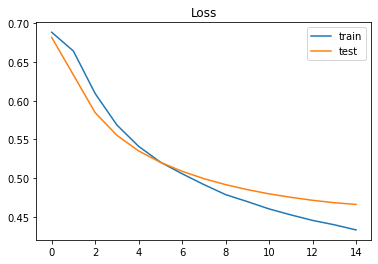

In [74]:
train_model(df)

## Using BERT for sentiment analysis

In [1]:
import os
import tensorflow as tf

os.environ['AUTOGRAPH_VERBOSITY'] = '5'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# Verbosity is now 5

tf.autograph.set_verbosity(0)
# Verbosity is now 0

import os

import tensorflow as tf

import pandas as pd
import tensorflow as tf
import numpy as np
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

import html
import re
from wordseg import segment
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_model(history):
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [3]:
def split_dataset(df, train_column_name, gold_column_name, test_percent=20):
    X_train, X_test, y_train, y_test = train_test_split(df[train_column_name], df[gold_column_name], test_size=test_percent, random_state=0)
    return X_train, X_test, y_train, y_test

In [4]:
def segment_hashtags(tweet):
    matches = re.findall(r'#[a-z0-9]+', tweet)
    for match in matches:
        tweet = re.sub(match, ' '.join(segment(match)[0]), tweet)
    return tweet

In [5]:
def clean_data(df):
    #Lowercase all tweets
    df['tweet'] = df['tweet'].progress_apply(lambda t: t.lower())
    #Decode HTML
    df['tweet'] = df['tweet'].progress_apply(lambda t: html.unescape(t))
    #Remove @ mentions
    df['tweet'] = df['tweet'].progress_apply(lambda t: re.sub(r'@[A-Za-z0-9]+','',t))
    #Remove URLs
    df['tweet'] = df['tweet'].progress_apply(lambda t: re.sub('https?://[A-Za-z0-9./]+','',t))
    #Segment hashtags
    df['tweet'] = df['tweet'].progress_apply(lambda t: segment_hashtags(t))
    #Remove remaining non-alpha characters
    df['tweet'] = df['tweet'].progress_apply(lambda t: re.sub("[^a-zA-Z]", " ", t))
    #Re-label positive tweets with 1 instead of 4
    df['sentiment'] = df['sentiment'].apply(lambda t: 1 if t==4 else t)
    return df

In [6]:
BATCH_SIZE = 32
DATASET_SIZE = 4000
english_twitter = "./twitter_english.csv"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_length = 200

In [7]:
def encode_data(df):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    for index, row in df.iterrows():
        tweet = row['tweet']
        label = row['sentiment']
        bert_input = tokenizer.encode_plus(
                        tweet,                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        max_length = max_length, # max length of the text that can go to BERT
                        padding='max_length', # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
                        truncation=True
            )        
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_inputs_to_dict)


In [8]:
def map_inputs_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [9]:
def prepare_dataset(df, size=int(DATASET_SIZE/2)):
    df = clean_data(df)
    df = pd.concat([df.head(size),df.tail(size)])
    df = df.sample(frac = 1)
    ds = encode_data(df)
    return ds

In [10]:
def get_test_train_val_datasets(ds, size=DATASET_SIZE, batch_size=BATCH_SIZE):
    ds.shuffle(32)
    train_size = int(0.7 * size)
    val_size = int(0.15 * size)
    test_size = int(0.15 * size)
    train_dataset = ds.take(train_size).batch(batch_size)
    test_dataset = ds.skip(train_size)
    val_dataset = test_dataset.skip(test_size).batch(batch_size)
    test_dataset = test_dataset.take(test_size).batch(batch_size)
    return (train_dataset, test_dataset, val_dataset)

In [11]:
def fine_tune_model(ds, export_dir):
    (train_dataset, test_dataset, val_dataset) = get_test_train_val_datasets(ds)
    learning_rate = 2e-5
    number_of_epochs = 1
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
    bert_history = model.fit(train_dataset, epochs=number_of_epochs, validation_data=val_dataset)
    model.save_pretrained(export_dir)
    return model

In [12]:
def load_existing_model(export_dir):
    model = TFBertForSequenceClassification.from_pretrained(export_dir)
    return model

In [13]:
def read_existing_file(filename):
    df = pd.read_csv(filename)
    df = df[['tweet', 'sentiment']]
    return df

In [14]:
df = read_existing_file(english_twitter)
dataset = prepare_dataset(df)

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

  0%|          | 0/148688 [00:00<?, ?it/s]

In [ ]:
model = fine_tune_model(dataset,'./bert_twitter_model')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
74/88 [========================>.....] - ETA: 33:20 - loss: 0.5971 - accuracy: 0.6736

In [ ]:
def encode_example(input_text):
    tokenized = tokenizer.tokenize(input_text)
    bert_input = tokenizer.encode_plus(
                    input_text,                      
                    add_special_tokens = True, # add [CLS], [SEP]
                    max_length = max_length, # max length of the text that can go to BERT
                    pad_to_max_length = True, # add [PAD] tokens
                    return_attention_mask = True, # add attention mask to not focus on pad tokens
                    return_tensors='tf',
                    padding='max_length'
        )
    return bert_input

In [ ]:
def test_new_example(model_path, tweet):
    model = load_existing_model(model_path)
    bert_input = encode_example(tweet)
    tf_output = model.predict([bert_input['input_ids'], bert_input['token_type_ids'], bert_input['attention_mask']])[0]
    tf_pred = tf.nn.softmax(tf_output, axis=1).numpy()[0]
    new_label = np.argmax(tf_pred, axis=-1)
    print(new_label)
    return new_label

In [ ]:
test_new_example('./bert_twitter_model', 'I hate going to the school')

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = []
    for tweet in X_test:
        bert_input = encode_example(tweet)
        tf_output = model.predict([bert_input['input_ids'], bert_input['token_type_ids'], bert_input['attention_mask']])[0]
        tf_pred = tf.nn.softmax(tf_output, axis=1).numpy()[0]
        new_label = np.argmax(tf_pred, axis=-1)
        y_pred.append(new_label)
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['negative', 'positive']))

In [ ]:
def load_and_evaluate_existing_model(export_dir, num_points=200):
    model = load_existing_model(export_dir)
    df = read_existing_file(english_twitter)
    df = clean_data(df)
    df = pd.concat([df.head(num_points),df.tail(num_points)])
    (X_train, X_test, y_train, y_test) = split_dataset(df, 'tweet', 'sentiment',20)
    evaluate_model(model, X_test, y_test)

In [ ]:
load_and_evaluate_existing_model('bert_twitter_model')